## Import libraries

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import math

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

## Logic Blocks

In [ ]:
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

# Spatial Attention Module
class SAM_Module(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.conv_1x1 = nn.Conv2d(in_channels=in_c, out_channels=1, kernel_size=1)

    def forward(self, x):
        attention_feature = torch.sigmoid(self.conv_1x1(x)).expand_as(x)
        SAM_output = attention_feature * x
        return SAM_output

In [ ]:
class CBM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,bn=True ,act='mish'):
    super(CBM,self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    if bn:
      self.bn   = nn.BatchNorm2d(out_channels)
    if act =='mish':
      self.mish = Mish()
    elif act == 'leakyrelu':
      self.leakyrelu = nn.LeakyReLU()
    elif act == 'relu':
      self.relu = nn.ReLU()
    # if attention:
    #   self.attention_module = SAM_Module()

  def forward(self,x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    if hasattr(self,'mish'):
      x = self.mish(x)
    elif hasattr(self,'leakyrelu'):
      x = self.leakyrelu(x)
    elif hasattr(self,'relu'):
      x = self.relu(x)
    return x

In [ ]:
class ResNetUnit(nn.Module):
  def __init__(self,in_c,out_c,bn=True,act='mish'): 
    super(ResNetUnit,self).__init__()
    self.cbm_1x1 = CBM(in_c, in_c,1,stride=1,padding=0,bn=True,act='mish') 
    self.cbm_3x3 = CBM(in_c,out_c,3,stride=1,padding=1,bn=True,act='mish')
  def forward(self,x):
    skip_connection = x
    x = self.cbm_1x1(x)
    x = self.cbm_3x3(x)
    x = skip_connection + x
    return x

In [ ]:
class CSP(nn.Module):
    CSP_num=1
    def __init__(self,in_c, num_resnet):
        super(CSP,self).__init__()
        self.in_c = in_c
#         print("CSP in_c",in_c)
        self.num_resnet = num_resnet

        self.cbm1_3x3 = CBM(in_c , in_c*2, 3, stride=2,padding=1,bn=True,act='mish')

        self.cbm2_1x1 = CBM(in_c*2 , in_c, 1, stride=1,padding=0,bn=True,act='mish')

        self.cbm3_1x1 = CBM(in_c*2 , in_c, 1, stride=1,padding=0,bn=True,act='mish')

        self.cbm4_resnet = nn.Sequential()
        for i in range(self.num_resnet):
            self.cbm4_resnet.add_module('ResNetUnit_{}_from_{}_CSP{}'.format(i,num_resnet,CSP.CSP_num),ResNetUnit(in_c,in_c,bn=True,act='mish') )

        self.cmb5_1x1 = CBM(in_c,in_c,1, stride=1,padding=0,bn=True,act='mish')

        self.cmb6_1x1 = CBM(in_c*2,in_c*2,1, stride=1, padding=0, bn=True, act='mish')
    

    def forward(self,x):

        inp = self.cbm1_3x3(x)

        skip_connection = self.cbm2_1x1(inp) 

        x = self.cbm3_1x1(inp)
        x = self.cbm4_resnet(x)
        x = self.cmb5_1x1(x)

        x = torch.cat([skip_connection,x],dim=1)

        x = self.cmb6_1x1(x)
        return x

In [ ]:
class first_CSP(nn.Module):
    def __init__(self,in_c):
        super(first_CSP,self).__init__()
        self.cbm1_3x3 = CBM(in_c, in_c*2, 3, stride=2,padding=1,bn=True,act='mish')

        self.cbm2_1x1 = CBM(in_c*2, in_c*2, 1, stride=1,padding=0,bn=True,act='mish')

        self.cbm3_1x1 = CBM(in_c*2, in_c*2, 1, stride=1,padding=0,bn=True,act='mish')
        self.cbm4_resnet = ResNetUnit(in_c*2, in_c*2, bn=True,act='mish') 
        self.cmb5_1x1 = CBM(in_c*2, in_c*2, 1, stride=1,padding=0,bn=True,act='mish')

        self.cmb6_1x1 = CBM(in_c*4, in_c*2, 1, stride=1, padding=0, bn=True, act='mish')


    def forward(self,x):
        inpu = self.cbm1_3x3(x)

        skip_connection = self.cbm2_1x1(inpu) 
        
        x = self.cbm3_1x1(inpu) 
        x = self.cbm4_resnet(x)
        x = self.cmb5_1x1(x)

        x = torch.cat([skip_connection,x],dim=1)
        x = self.cmb6_1x1(x)
        return x

In [ ]:
class SPP(nn.Module):
  def __init__(self):
    super(SPP,self).__init__()
    self.maxpool_5x5   = nn.MaxPool2d(kernel_size= 5 , stride=1, padding=2)
    self.maxpool_9x9   = nn.MaxPool2d(kernel_size= 9 , stride=1, padding=4)
    self.maxpool_13x13 = nn.MaxPool2d(kernel_size=13 , stride=1, padding=6)
  def forward(self,x):
    skip_connection = x
    out1 = self.maxpool_5x5(x)
    out2 = self.maxpool_9x9(x)
    out3 = self.maxpool_13x13(x)
    x = torch.cat([skip_connection,out1,out2,out3],dim=1)
    return x


In [ ]:
class CBL(nn.Module):
  def __init__(self, in_c, out_c, kernel_size, stride=1, padding=0,act='leakyrelu'):
    super(CBL,self).__init__()
    self.act  = act
    self.conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)  #Conv2d(in_channels, out_channels, kernel_size , stride, padding)
    self.bn   = nn.BatchNorm2d(out_c)
    self.leakyrelu = nn.LeakyReLU()

  def forward(self,x):
    x = self.conv(x)
    if (self.act != None):
        x = self.bn(x)
        x = self.leakyrelu(x)
        
    return x

In [ ]:
class CBLx5 (nn.Module):
  def __init__(self, in_c):
    super(CBLx5,self).__init__()
    out_c = int(in_c/2)
    self.conv1 = CBL(in_c, out_c, kernel_size=1, stride=1, padding=0,act='leakyrelu')
    self.conv2 = CBL(out_c, in_c, kernel_size=3, stride=1, padding=1,act='leakyrelu')
    self.conv3 = CBL(in_c, out_c, kernel_size=1, stride=1, padding=0,act='leakyrelu')
    self.conv4 = CBL(out_c, in_c, kernel_size=3, stride=1, padding=1,act='leakyrelu')
    self.conv5 = CBL(in_c, out_c, kernel_size=1, stride=1, padding=0,act='leakyrelu')

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    return x

In [ ]:
class CBLx3_1(nn.Module):  #After BackBone
  def __init__(self):
    super(CBLx3_1,self).__init__()
    self.conv_1x1_1 = CBL(in_c=1024, out_c=512,  kernel_size=1, stride=1, padding=0,act='leakyrelu')
    self.conv_3x3   = CBL(in_c=512,  out_c=1024, kernel_size=3, stride=1, padding=1,act='leakyrelu')
    self.conv_1x1_2 = CBL(in_c=1024, out_c=512,  kernel_size=1, stride=1, padding=0,act='leakyrelu')
  def forward(self,x):      #C =1024 (BackBone output)
    x = self.conv_1x1_1(x)  #C = 512
    x = self.conv_3x3(x)    #C = 1024
    x = self.conv_1x1_2(x)  #C = 512
    return x

class CBLx3_2(nn.Module):  #After SPP
  def __init__(self):
    super(CBLx3_2,self).__init__()
    self.conv_1x1_1 = CBL(in_c=2048, out_c=512,  kernel_size=1, stride=1, padding=0,act='leakyrelu')
    self.conv_3x3   = CBL(in_c=512,  out_c=1024, kernel_size=3, stride=1, padding=1,act='leakyrelu')
    self.conv_1x1_2 = CBL(in_c=1024, out_c=512,  kernel_size=1, stride=1, padding=0,act='leakyrelu')
  def forward(self,x):      #C = 2048 (BackBone output)
    x = self.conv_1x1_1(x)  #C = 512
    x = self.conv_3x3(x)    #C = 1024
    x = self.conv_1x1_2(x)  #C = 512
    return x   

In [ ]:
class FPN_Lateral_Connection(nn.Module):
  def __init__(self,in_c,out_c):
    super(FPN_Lateral_Connection,self).__init__()
    self.in_c  = in_c 
    self.out_c = out_c
    self.cbl_1x1_upsample = CBL(in_c, out_c, kernel_size=1, stride=1, padding=0,act='leakyrelu')
    self.upsample         = nn.Upsample(scale_factor=2, mode='nearest') 
    
    self.cbl_1x1          = CBL(in_c, out_c, kernel_size=1, stride=1, padding=0,act='leakyrelu')
    self.cblx5            = CBLx5(in_c=in_c)
  def forward(self,top_x, x): 
    out1 = self.cbl_1x1_upsample(top_x)   
    out1 = self.upsample(out1)            

    out2 = self.cbl_1x1(x)                
    
    x = torch.cat([out1,out2],dim=1)


    x = self.cblx5(x)                    
    return x


In [ ]:
class PAN_Lateral_Connection(nn.Module):
  def __init__(self,out_c):
    super(PAN_Lateral_Connection,self).__init__()
    self.cbl_3x3 = CBL(int(out_c/2), out_c, kernel_size=3, stride=2, padding=1,act='leakyrelu')

    self.cblx5 = CBLx5(in_c=out_c*2)
  def forward(self,down_x,x):
    out1 = self.cbl_3x3(down_x) 

    x = torch.cat([out1,x],dim=1)

    x = self.cblx5(x)
    return x

## YOLO BackBone -> Neck -> Head

In [ ]:
class CSPDarknet53(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = CBM(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1 ,bn=True ,act='mish') 

    self.first_csp = first_CSP(in_c=32) 
    self.csp2      = CSP(in_c=64, num_resnet=2) 
    self.csp8      = CSP(in_c=128, num_resnet=2) 
    self.csp8_2    = CSP(in_c=256, num_resnet=2) 
    self.csp4      = CSP(in_c=512, num_resnet=2) 
    
  def forward(self,x):
    x = self.conv1(x)     
    x = self.first_csp(x) 
    x = self.csp2(x)      
    x_s = self.csp8(x)    
    x_m = self.csp8_2(x_s)  
    x_l = self.csp4(x_m)  
    return x_s, x_m, x_l

In [ ]:
class Neck(nn.Module):
  def __init__(self):
    super(Neck,self).__init__()
    self.cblx3_1 = CBLx3_1() 
    self.spp     = SPP()     
    self.cblx3_2 = CBLx3_2() 

    self.fpn_medium = FPN_Lateral_Connection(in_c=512,out_c=256)   
    self.fpn_small  = FPN_Lateral_Connection(in_c=256,out_c=128)  

    self.pan_medium = PAN_Lateral_Connection(out_c=256)  
    self.pan_large  = PAN_Lateral_Connection(out_c=512)  

  def forward(self,backbone):           
    x_s,x_m,x_l = backbone
    spp_x_l = self.cblx3_1(x_l)      
    spp_x_l = self.spp(spp_x_l)         
    spp_x_l = self.cblx3_2(spp_x_l)      

    fpn_x_l = spp_x_l                            
    fpn_x_m = self.fpn_medium(fpn_x_l, x_m)       
    fpn_x_s = self.fpn_small (fpn_x_m, x_s)      

    pan_x_s = fpn_x_s                             
    pan_x_m = self.pan_medium(pan_x_s, fpn_x_m)   
    pan_x_l = self.pan_large (pan_x_m, fpn_x_l)  

    return pan_x_s, pan_x_m, pan_x_l

In [ ]:
class YOLO_head(nn.Module):
  def __init__(self, in_c, num_anchor, num_class):
    super().__init__()
    self.final_c = num_anchor * (5 + num_class)
    self.cbl_3x3 = CBL(in_c , in_c*2       , kernel_size=3, stride=1, padding=1,act='leakyrelu')  
    self.cbl_1x1 = CBL(in_c*2, self.final_c, kernel_size=1, stride=1, padding=0,act=None) 
  def forward(self,pan_x):
    x = self.cbl_3x3(pan_x) 
    x = self.cbl_1x1(x)
    return x

## YOLO Layer

In [ ]:
'''
Reference: https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/47b7c912877ca69db35b8af3a38d6522681b3bb3/models.py#L106
'''
class YOLO_Layer(nn.Module):
    def __init__(self,  anchors, num_classes, img_dim=608):
        super(YOLO_Layer,self).__init__()

        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0
        
    def forward(self, x, targets=None):
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor

        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, 5 + self.num_classes , grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        x = torch.sigmoid(prediction[..., 0])  
        y = torch.sigmoid(prediction[..., 1])  
        w = prediction[..., 2]  
        h = prediction[..., 3] 
        pred_conf = torch.sigmoid(prediction[..., 4]) 
        pred_cls = torch.sigmoid(prediction[..., 5:]) 


        self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x + self.grid_x
        pred_boxes[..., 1] = y + self.grid_y
        pred_boxes[..., 2] = torch.exp(w) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h) * self.anchor_h

        # Output Shape = [ Batch_size, Total_YOLO_anchors , 5+num_class ]
        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0

        iou, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf, target_boxes = self.build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres
        )

        xc1, yc1, xc2, yc2 = self.smallestenclosing(pred_boxes[obj_mask], target_boxes[obj_mask])
        c = ((xc2 - xc1) ** 2) + ((yc2 - yc1) ** 2) + 1e-7

        d = (tx[obj_mask] - x[obj_mask]) ** 2 + (ty[obj_mask] - y[obj_mask]) ** 2

        rDIoU = d/c

        iou_masked = iou[obj_mask]
        v = (4 / (math.pi ** 2)) * torch.pow((torch.atan(tw[obj_mask]/th[obj_mask])-torch.atan(w[obj_mask]/h[obj_mask])), 2)

        with torch.no_grad():
            S = 1 - iou_masked
            alpha = v / (S + v + 1e-7)

        CIoUloss = (1 - iou_masked + rDIoU + alpha * v).sum(0)/num_samples
        loss_conf_obj = F.binary_cross_entropy(pred_conf[obj_mask], tconf[obj_mask])
        loss_conf_noobj = F.binary_cross_entropy(pred_conf[noobj_mask], tconf[noobj_mask])
        loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
        
#         print("pred_cls[obj_mask]",pred_cls[obj_mask])
#         print("target=tcls[obj_mask]",tcls[obj_mask])
        loss_cls = F.binary_cross_entropy(input=pred_cls[obj_mask], target=tcls[obj_mask])
        
#         CIoUloss = 0
#         loss_conf = 0
#         print("CIoUloss",CIoUloss)
#         print("loss_cls",loss_cls)
#         print("loss_conf",loss_conf)
#         print("loss_conf_obj",loss_conf_obj)
#         print("loss_conf_noobj",loss_conf_noobj)
    
        total_loss = CIoUloss + loss_cls + loss_conf

        return output, total_loss, CIoUloss , loss_cls , loss_conf

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)    
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1)) 
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1)) 

    def bbox_wh_iou(self, wh1, wh2):
        wh2 = wh2.t()
        w1, h1 = wh1[0], wh1[1]
        w2, h2 = wh2[0], wh2[1]
        inter_area = torch.min(w1, w2) * torch.min(h1, h2)
        union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
        return inter_area / union_area


    def bbox_iou(self, box1, box2, x1y1x2y2=True, get_areas = False):
        if not x1y1x2y2:
            b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
            b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
            b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
            b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
        else:
            b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
            b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

        inter_rect_x1 = torch.max(b1_x1, b2_x1)
        inter_rect_y1 = torch.max(b1_y1, b2_y1)
        inter_rect_x2 = torch.min(b1_x2, b2_x2)
        inter_rect_y2 = torch.min(b1_y2, b2_y2)
    
        inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1, min=0) * torch.clamp(
            inter_rect_y2 - inter_rect_y1, min=0
        )

        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
        union_area = (b1_area + b2_area - inter_area + 1e-16)

        if get_areas:
            return inter_area, union_area

        iou = inter_area / union_area
        return iou


    def smallestenclosing(self, pred_boxes, target_boxes):
        targetxc = target_boxes[..., 0]
        targetyc = target_boxes[..., 1]
        targetwidth = target_boxes[..., 2]
        targetheight = target_boxes[..., 3]

        predxc = pred_boxes[..., 0]
        predyc = pred_boxes[..., 1]
        predwidth = pred_boxes[..., 2]
        predheight = pred_boxes[..., 3]

        xc1 = torch.min(predxc - (predwidth/2), targetxc - (targetwidth/2))
        yc1 = torch.min(predyc - (predheight/2), targetyc - (targetheight/2))
        xc2 = torch.max(predxc + (predwidth/2), targetxc + (targetwidth/2))
        yc2 = torch.max(predyc + (predheight/2), targetyc + (targetheight/2))

        return xc1, yc1, xc2, yc2

    def xywh2xyxy(self, x):
        y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
        y[:, 0] = x[:, 0] - x[:, 2] / 2
        y[:, 1] = x[:, 1] - x[:, 3] / 2
        y[:, 2] = x[:, 0] + x[:, 2] / 2
        y[:, 3] = x[:, 1] + x[:, 3] / 2
        return y
  
  
    def build_targets(self, pred_boxes, pred_cls, target, anchors, ignore_thres):
        ByteTensor = torch.cuda.BoolTensor if pred_boxes.is_cuda else torch.BoolTensor
        FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

        nB = pred_boxes.size(0)
        nA = pred_boxes.size(1)
        nC = pred_cls.size(-1)
        nG = pred_boxes.size(2)

        obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
        noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
        class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
        iou = FloatTensor(nB, nA, nG, nG).fill_(0)
        tx = FloatTensor(nB, nA, nG, nG).fill_(0)
        ty = FloatTensor(nB, nA, nG, nG).fill_(0)
        tw = FloatTensor(nB, nA, nG, nG).fill_(0)
        th = FloatTensor(nB, nA, nG, nG).fill_(0)
        tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

        target_boxes_grid = FloatTensor(nB, nA, nG, nG, 4).fill_(0)
        
        target_boxes = target[:, 2:6] * nG
        gxy = target_boxes[:, :2]
        gwh = target_boxes[:, 2:]

        ious = torch.stack([self.bbox_wh_iou(anchor, gwh) for anchor in anchors])
     
        best_ious, best_n = ious.max(0)

        b, target_labels = target[:, :2].long().t()
        gx, gy = gxy.t()
        gw, gh = gwh.t()
        gi, gj = gxy.long().t()

        target_boxes_grid[b, best_n, gj, gi] = target_boxes

        obj_mask[b, best_n, gj, gi] = 1
        noobj_mask[b, best_n, gj, gi] = 0

        for i, anchor_ious in enumerate(ious.t()):
            noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

        tx[b, best_n, gj, gi] = gx - gx.floor()
        ty[b, best_n, gj, gi] = gy - gy.floor()

        tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
        th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)

        tcls[b, best_n, gj, gi, target_labels] = 0.99

        class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
        iou[b, best_n, gj, gi] = self.bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

        tconf = obj_mask.float()

        return iou, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf, target_boxes_grid


    


## YOLOV4 Model

In [ ]:
class YOLOv4(nn.Module):
  def __init__(self,num_anchor=None, num_class=2,img_dim=608,anchors=None): 
    super(YOLOv4,self).__init__()
    if anchors is None:
        anchors = [[[ 58,  50]],
                   [[159, 177]],
                   [[285, 202]]]
#       anchors = [[[10, 13], [16, 30], [33, 23]],
#                  [[30, 61], [62, 45], [59, 119]],
#                 [[116, 90], [156, 198], [373, 326]]]
    self.img_dim = img_dim

    num_anchor = len(anchors)
    self.csp_darknet53   = CSPDarknet53()
    self.neck            = Neck()

#     self.yolo_head_large   = YOLO_head(512, 3, num_class)  #  def __init__(self, in_c, num_anchor, num_class):
#     self.yolo_head_medium  = YOLO_head(256, 3, num_class)  
#     self.yolo_head_small   = YOLO_head(128, 3 , num_class)  
    
    self.yolo_head_large   = YOLO_head(512, 1, num_class)  #  def __init__(self, in_c, num_anchor, num_class):
    self.yolo_head_medium  = YOLO_head(256, 1, num_class)  
    self.yolo_head_small   = YOLO_head(128, 1 , num_class)
    
    self.yolo_layer_large  = YOLO_Layer(anchors[2], num_class, img_dim) 
    self.yolo_layer_medium = YOLO_Layer(anchors[1], num_class, img_dim) 
    self.yolo_layer_small  = YOLO_Layer(anchors[0], num_class, img_dim)                   

  def forward(self,x,targets):
    x_s, x_m, x_l             = self.csp_darknet53(x) 
    backbone                  = [x_s,x_m,x_l]         
    pan_x_s, pan_x_m, pan_x_l = self.neck(backbone) 
    yolo_head_l              = self.yolo_head_large(pan_x_l)  
    yolo_head_m              = self.yolo_head_medium(pan_x_m) 
    yolo_head_s              = self.yolo_head_small(pan_x_s) 

    out_l , loss_l , CIoUloss_l , loss_cls_l , loss_conf_l  = self.yolo_layer_large (yolo_head_l,targets) 
    out_m , loss_m , CIoUloss_m , loss_cls_m , loss_conf_m  = self.yolo_layer_medium(yolo_head_m,targets)
    out_s , loss_s , CIoUloss_s , loss_cls_s , loss_conf_s  = self.yolo_layer_small (yolo_head_s,targets)

    out_l = out_l.detach()
    out_m = out_m.detach()
    out_s = out_s.detach()

    final_out  = torch.cat((out_l, out_m, out_s), dim=1) # final_out Shape = [ Batch_size, Total_YOLO_anchors , 5+num_class ]
    total_loss = (loss_l + loss_m + loss_s) / 3
    CIoUloss   = (CIoUloss_l + CIoUloss_m + CIoUloss_s) / 3
    loss_cls   = (loss_cls_l + loss_cls_m + loss_cls_s) / 3
    loss_conf  = (loss_conf_l + loss_conf_m + loss_conf_s) / 3
    
#     return out_l,loss_l

    return final_out, total_loss, CIoUloss, loss_cls, loss_conf

## Model Object

In [ ]:
img_dim  = 320
img_size = 320


In [ ]:
# model = YOLOv4(img_dim=416).to('cuda')

## Dataloader

In [ ]:
import torch 
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
import glob2
import numpy as np
import albumentations as A 
from albumentations.pytorch import ToTensor
import cv2



In [ ]:
class yolo_image_dataset(Dataset):
    def __init__(self,image_path,label_path, transform_albumentations):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.transform_albumentations  = transform_albumentations
        self.imagelist        = glob2.glob(self.image_path+"/*jpg")

    def __getitem__(self,index):
        image_path  = self.imagelist[index]
        image       = Image.open(image_path)
        image_type = image.mode
        
        image_array = np.array(image)
#         print("image_path",image_path)
        
        if(image_type != 'RGB'):
            im = image_array
            w, h = im.shape
            image_array = np.empty((w, h, 3), dtype=np.uint8)
            image_array[:, :, 2] =  image_array[:, :, 1] =  image_array[:, :, 0] =  im

        image_filename = image_path.split("/")[-1]      
        image_filename = image_filename.split(".")[0]  

        label_path = self.label_path + "/" + image_filename + ".txt"
        label_file_list = open(label_path,'r').read().splitlines()  
        albumentations_bbox = []  
        category_ids = []
        for line in label_file_list:
            anno = line.split(" ")
            X , Y , W, H, class_id  = float(anno[1]),float(anno[2]),float(anno[3]),float(anno[4]) , int (anno[0])
#             single_box = [ X , Y , W , H, class_id] 
            single_box = [min(X,0.995), min(Y,0.995), min(W,0.995) , min(H,0.995) , class_id]
            albumentations_bbox.append(single_box)
            category_ids.append(class_id )
        
        transformed_albumentations = self.transform_albumentations(image=image_array, bboxes=albumentations_bbox)
        image = transformed_albumentations['image']   
        bbox  = transformed_albumentations['bboxes'] 
        bbox_tensor = torch.tensor(bbox) 
        if len(bbox_tensor) > 0:
            bbox_tensor = torch.index_select(bbox_tensor,1,torch.LongTensor([4,0,1,2,3])) 
        else:
            target = torch.tensor([])
            return image_path , image , target
#             bbox_tensor = torch.zeros(1,5)  
            
        target = torch.zeros(len(bbox),6)
        target[:,1:] = bbox_tensor

        return  image_path , image , target   
    
    
    def collate_fn(self,batch):   
        img_paths , imgs , targets = list(zip(*batch)) 
        
        i = 0
        for target in targets:  #target for each image
            # target= list of [img_id,class_id,X,Y,W,H] for each bbox in a given image 
            if len(target) > 0:  # No empty target , No tensor([])
                target[:,0] = i  # Update img_id  
            i = i+1
                
        targets = [boxes for boxes in targets if boxes is not None] #Remove empty bbox from target
        target_tensor = torch.cat(targets, 0) 

        imgs = torch.stack([img for img in imgs])

        return img_paths, imgs, target_tensor
    
        
    def __len__(self): 
        total_images = len(self.imagelist)
        return total_images

In [ ]:
transform_albumentations = A.Compose([
    A.SmallestMaxSize(max_size=img_size,interpolation=cv2.INTER_LINEAR) ,
    A.RandomCrop(height=img_size, width=img_size),  
#     A.Normalize(), 
    ToTensor() 
], bbox_params=A.BboxParams(format='yolo' )) 

test_dataset    = yolo_image_dataset(image_path='images/', label_path='labels/',transform_albumentations=transform_albumentations)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=8 ,collate_fn=test_dataset.collate_fn, shuffle = True)


In [ ]:
model_det = YOLOv4(img_dim=img_dim).to('cuda')
model_det.load_state_dict(torch.load('model_classification_weight_only.pt'))


EPOCHS = 200
device = 'cuda'
optimizer = torch.optim.SGD(model_det.parameters(),lr=0.002)  # 0001
# optimizer = torch.optim.Adam(model_det.parameters(), lr=0.00000001)
import time
import copy
from torch.autograd import Variable

total_loss_list = []
total_CIOU_list = []
total_cls_list  = []
total_conf_list  = []

total_loss = 0
total_CIOU = 0
total_cls = 0
total_cnf = 0
loss = 1
outputs = 1
for epoch in range(EPOCHS):
    del total_loss
    del total_CIOU
    del total_cls
    del total_cnf
    total_loss = 0
    total_CIOU = 0
    total_cls = 0
    total_cnf = 0
    num_iter   = 0 
    model_det.train()
    print("epoch",epoch)
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(test_dataloader):
        batches_done = len(test_dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)
        del loss
        del outputs
        outputs, loss, CIoUloss, loss_cls, loss_conf = model_det(imgs, targets)
#         print("[INFO] loss",loss)
#         loss = Variable(loss, requires_grad = True)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss = total_loss + copy.copy(loss.item() )
        total_CIOU = total_CIOU + copy.copy(CIoUloss.item() )
        total_cls  = total_cls + copy.copy(loss_cls.item() )
        total_cnf  = total_cnf+ copy.copy(loss_conf.item() )
        num_iter += 1
        
    if (epoch%15==0):
        savename = './model_det'+str(epoch)+".pth"
        torch.save(model_det, savename)   
    print("Total Loss:{:.6f}    CIOULoss:{:.6f}    Cls_Loss:{:.6f}    Conf_Loss:{:.6f}".format(total_loss/num_iter, total_CIOU/num_iter, total_cls/num_iter, total_cnf/num_iter))
    total_loss_list.append(total_loss/num_iter)
    total_CIOU_list.append(total_CIOU/num_iter)
    total_cls_list.append(total_cls/num_iter)
    total_conf_list.append(total_cnf/num_iter)
#     total_loss.append(loss)

epoch 0


/root/anaconda3/envs/maulik_py38/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type YOLOv4. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/root/anaconda3/envs/maulik_py38/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type CSPDarknet53. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/root/anaconda3/envs/maulik_py38/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type CBM. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/root/anaconda3/envs/maulik_py38/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Mish. It 

Total Loss:7.491199    CIOULoss:1.136956    Cls_Loss:0.380225    Conf_Loss:5.974018
epoch 1
Total Loss:6.121696    CIOULoss:1.026819    Cls_Loss:0.344227    Conf_Loss:4.750650
epoch 2
Total Loss:5.752954    CIOULoss:0.991110    Cls_Loss:0.296830    Conf_Loss:4.465014
epoch 3
Total Loss:5.386081    CIOULoss:0.976846    Cls_Loss:0.271326    Conf_Loss:4.137910
epoch 4
Total Loss:5.347071    CIOULoss:0.989361    Cls_Loss:0.300592    Conf_Loss:4.057118
epoch 5
Total Loss:5.205735    CIOULoss:0.973714    Cls_Loss:0.283189    Conf_Loss:3.948831
epoch 6
Total Loss:4.991511    CIOULoss:0.925032    Cls_Loss:0.260009    Conf_Loss:3.806470
epoch 7
Total Loss:4.957967    CIOULoss:0.936393    Cls_Loss:0.242898    Conf_Loss:3.778676
epoch 8
Total Loss:4.861213    CIOULoss:0.936864    Cls_Loss:0.228395    Conf_Loss:3.695954
epoch 9
Total Loss:4.800125    CIOULoss:0.941397    Cls_Loss:0.217450    Conf_Loss:3.641278
epoch 10
Total Loss:5.049667    CIOULoss:1.009699    Cls_Loss:0.253010    Conf_Loss:3.78

In [ ]:
torch.save(model_det.state_dict(), './final.pth')


In [ ]:
torch.save(model_det, './final.pt')


## loss Graph

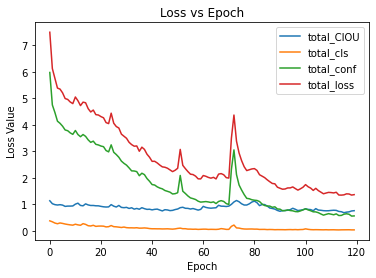

In [ ]:
import pickle
from matplotlib import pyplot as plt

total_CIOU = pickle.load( open( "total_CIOU_list.pkl", "rb" ) )
total_cls  = pickle.load( open( "total_cls_list.pkl" , "rb" ) )
total_conf = pickle.load( open( "total_conf_list.pkl", "rb" ) )
total_loss = pickle.load( open( "total_loss_list.pkl", "rb" ) )

X = list(range(120))
plt.plot(X, total_CIOU[:120], label = "total_CIOU")
plt.plot(X, total_cls[:120] , label = "total_cls")
plt.plot(X, total_conf[:120], label = "total_conf")
plt.plot(X, total_loss[:120], label = "total_loss")
plt.legend()

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

plt.savefig("lossvsepoch.png")
